In [97]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import shutil
%matplotlib inline

In [98]:
project_name = 'CAT-dcgan'

In [99]:
!mkdir cats-faces-64x64-for-generative-models

mkdir: cannot create directory ‘cats-faces-64x64-for-generative-models’: File exists


In [100]:
DATA_DIR = '/content/cats-faces-64x64-for-generative-models'

In [101]:
print(os.listdir(DATA_DIR))

['cats']


In [102]:
checkpoint_dir = os.path.join(DATA_DIR, '.ipynb_checkpoints')

if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)
    print(f"Deleted {checkpoint_dir}")
else:
    print(f"{checkpoint_dir} does not exist")

/content/cats-faces-64x64-for-generative-models/.ipynb_checkpoints does not exist


In [103]:
print(os.listdir(DATA_DIR+'/cats')[:10])

['2136.jpg', '3787.jpg', '3053.jpg', '531.jpg', '2559.jpg', '2461.jpg', '1780.jpg', '1389.jpg', '3704.jpg', '1558.jpg']


In [104]:
image_size = 64
batch_size = 32
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [105]:
train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [106]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [107]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [108]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

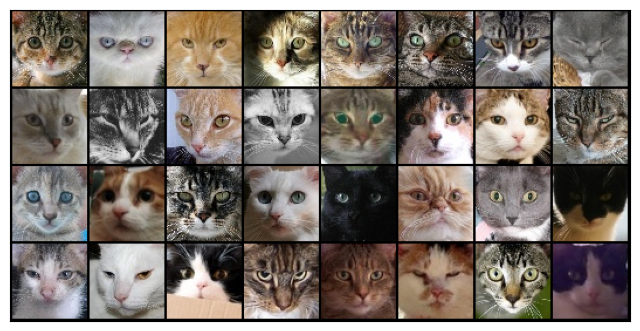

In [109]:
show_batch(train_dl)

In [110]:
!pip install jovian --upgrade --quiet

In [111]:
import jovian

In [112]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


In [113]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [114]:
device = get_default_device()
device

device(type='cuda')

In [115]:
train_dl = DeviceDataLoader(train_dl, device)

In [116]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [117]:
discriminator = to_device(discriminator, device)

In [118]:
latent_size = 128

In [119]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([32, 3, 64, 64])


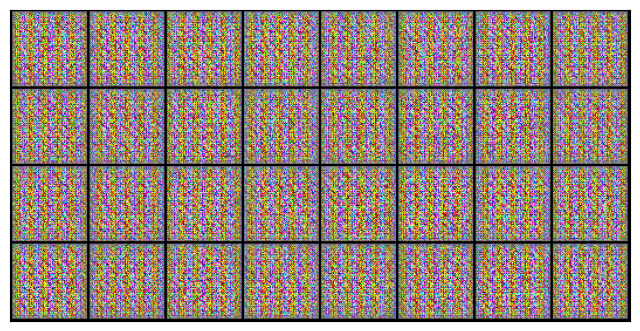

In [120]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [121]:
generator = to_device(generator, device)

In [122]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [123]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [124]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [125]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [126]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


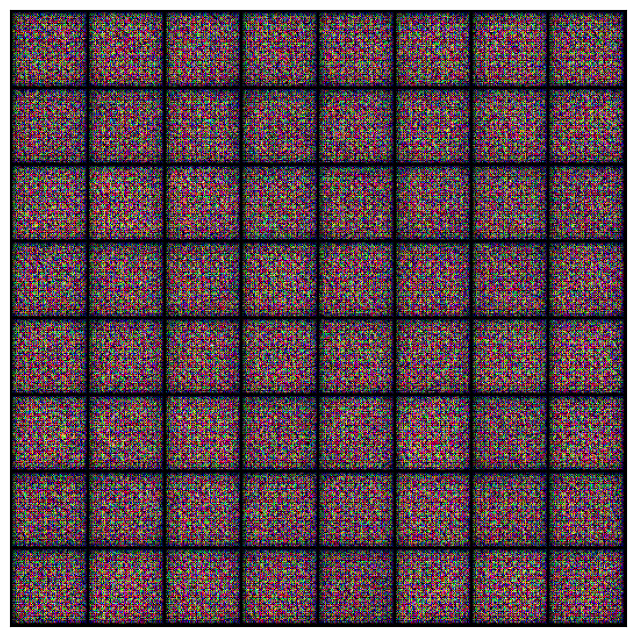

In [127]:
save_samples(0, fixed_latent)

In [128]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [129]:
lr = 0.0002
epochs = 100

In [130]:
history = fit(epochs, lr)

  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 7.3400, loss_d: 1.0367, real_score: 0.9812, fake_score: 0.5927
Saving generated-images-0001.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 4.2234, loss_d: 0.3876, real_score: 0.7412, fake_score: 0.0210
Saving generated-images-0002.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 3.1375, loss_d: 1.0960, real_score: 0.5478, fake_score: 0.2008
Saving generated-images-0003.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 6.0662, loss_d: 0.5797, real_score: 0.9803, fake_score: 0.3959
Saving generated-images-0004.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 2.4390, loss_d: 0.8201, real_score: 0.6151, fake_score: 0.1897
Saving generated-images-0005.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 4.0665, loss_d: 0.2340, real_score: 0.9183, fake_score: 0.1258
Saving generated-images-0006.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 10.3083, loss_d: 1.0027, real_score: 0.9935, fake_score: 0.5022
Saving generated-images-0007.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 3.2163, loss_d: 0.2351, real_score: 0.9110, fake_score: 0.0847
Saving generated-images-0008.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 7.2468, loss_d: 0.3180, real_score: 0.7649, fake_score: 0.0108
Saving generated-images-0009.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 4.1532, loss_d: 0.0717, real_score: 0.9682, fake_score: 0.0367
Saving generated-images-0010.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 4.7269, loss_d: 0.3092, real_score: 0.9153, fake_score: 0.1793
Saving generated-images-0011.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 4.5803, loss_d: 0.1066, real_score: 0.9667, fake_score: 0.0682
Saving generated-images-0012.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 4.8294, loss_d: 0.3174, real_score: 0.9284, fake_score: 0.1961
Saving generated-images-0013.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 4.0524, loss_d: 0.0961, real_score: 0.9867, fake_score: 0.0769
Saving generated-images-0014.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 8.0676, loss_d: 5.1090, real_score: 0.0126, fake_score: 0.0000
Saving generated-images-0015.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 10.7658, loss_d: 6.4242, real_score: 0.0042, fake_score: 0.0000
Saving generated-images-0016.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 3.6517, loss_d: 0.4710, real_score: 0.6921, fake_score: 0.0442
Saving generated-images-0017.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 5.1685, loss_d: 0.2072, real_score: 0.8749, fake_score: 0.0639
Saving generated-images-0018.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 3.9374, loss_d: 0.2472, real_score: 0.8221, fake_score: 0.0098
Saving generated-images-0019.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 8.1119, loss_d: 0.6147, real_score: 0.5839, fake_score: 0.0010
Saving generated-images-0020.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 3.9572, loss_d: 0.3451, real_score: 0.7579, fake_score: 0.0285
Saving generated-images-0021.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 4.4990, loss_d: 0.2305, real_score: 0.8640, fake_score: 0.0662
Saving generated-images-0022.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 7.0700, loss_d: 0.5828, real_score: 0.9798, fake_score: 0.3740
Saving generated-images-0023.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 6.5484, loss_d: 0.0435, real_score: 0.9655, fake_score: 0.0075
Saving generated-images-0024.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 3.2748, loss_d: 0.1629, real_score: 0.8813, fake_score: 0.0288
Saving generated-images-0025.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 10.8673, loss_d: 2.9537, real_score: 0.1275, fake_score: 0.0000
Saving generated-images-0026.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 7.7792, loss_d: 0.1890, real_score: 0.8428, fake_score: 0.0004
Saving generated-images-0027.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 4.2748, loss_d: 0.0840, real_score: 0.9432, fake_score: 0.0216
Saving generated-images-0028.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 4.8980, loss_d: 0.0935, real_score: 0.9243, fake_score: 0.0064
Saving generated-images-0029.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 6.4261, loss_d: 0.0405, real_score: 0.9633, fake_score: 0.0015
Saving generated-images-0030.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 9.1948, loss_d: 0.0362, real_score: 0.9664, fake_score: 0.0001
Saving generated-images-0031.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 6.1238, loss_d: 0.0078, real_score: 0.9975, fake_score: 0.0053
Saving generated-images-0032.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 9.8661, loss_d: 0.0052, real_score: 0.9950, fake_score: 0.0001
Saving generated-images-0033.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 6.3618, loss_d: 0.1733, real_score: 0.9852, fake_score: 0.1327
Saving generated-images-0034.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 10.1122, loss_d: 4.3692, real_score: 0.0231, fake_score: 0.0000
Saving generated-images-0035.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 12.0151, loss_d: 0.0092, real_score: 0.9909, fake_score: 0.0000
Saving generated-images-0036.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 7.2925, loss_d: 0.0213, real_score: 0.9828, fake_score: 0.0037
Saving generated-images-0037.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 7.9045, loss_d: 0.1719, real_score: 0.8569, fake_score: 0.0029
Saving generated-images-0038.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 7.5321, loss_d: 0.0107, real_score: 0.9920, fake_score: 0.0026
Saving generated-images-0039.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 4.6326, loss_d: 0.2058, real_score: 0.9873, fake_score: 0.1573
Saving generated-images-0040.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 8.9235, loss_d: 0.0021, real_score: 0.9983, fake_score: 0.0004
Saving generated-images-0041.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 7.4026, loss_d: 0.0573, real_score: 0.9480, fake_score: 0.0018
Saving generated-images-0042.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 4.3436, loss_d: 0.0499, real_score: 0.9970, fake_score: 0.0445
Saving generated-images-0043.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 5.4793, loss_d: 0.0258, real_score: 0.9988, fake_score: 0.0241
Saving generated-images-0044.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 6.3975, loss_d: 0.0083, real_score: 0.9933, fake_score: 0.0015
Saving generated-images-0045.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 7.3427, loss_d: 0.0092, real_score: 0.9919, fake_score: 0.0011
Saving generated-images-0046.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 5.5381, loss_d: 0.1101, real_score: 0.9235, fake_score: 0.0235
Saving generated-images-0047.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 8.3823, loss_d: 0.0047, real_score: 0.9960, fake_score: 0.0006
Saving generated-images-0048.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 7.3273, loss_d: 0.0656, real_score: 0.9404, fake_score: 0.0010
Saving generated-images-0049.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 5.4261, loss_d: 0.0671, real_score: 0.9594, fake_score: 0.0239
Saving generated-images-0050.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 9.0660, loss_d: 0.0118, real_score: 0.9889, fake_score: 0.0003
Saving generated-images-0051.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 4.8759, loss_d: 0.0178, real_score: 0.9968, fake_score: 0.0142
Saving generated-images-0052.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 6.9932, loss_d: 0.0132, real_score: 0.9995, fake_score: 0.0122
Saving generated-images-0053.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 9.2432, loss_d: 0.0470, real_score: 0.9558, fake_score: 0.0001
Saving generated-images-0054.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 11.8450, loss_d: 0.7287, real_score: 0.5904, fake_score: 0.0001
Saving generated-images-0055.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 5.9500, loss_d: 0.0631, real_score: 0.9510, fake_score: 0.0115
Saving generated-images-0056.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 6.1207, loss_d: 0.0434, real_score: 0.9946, fake_score: 0.0359
Saving generated-images-0057.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 10.7927, loss_d: 0.0043, real_score: 0.9958, fake_score: 0.0000
Saving generated-images-0058.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 4.9977, loss_d: 0.0614, real_score: 0.9898, fake_score: 0.0483
Saving generated-images-0059.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 9.4159, loss_d: 0.0887, real_score: 0.9191, fake_score: 0.0003
Saving generated-images-0060.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 6.8392, loss_d: 0.0456, real_score: 0.9711, fake_score: 0.0122
Saving generated-images-0061.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 6.6876, loss_d: 0.0198, real_score: 0.9827, fake_score: 0.0019
Saving generated-images-0062.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 5.2499, loss_d: 0.0109, real_score: 0.9971, fake_score: 0.0078
Saving generated-images-0063.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 6.0209, loss_d: 0.1009, real_score: 0.9344, fake_score: 0.0271
Saving generated-images-0064.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 8.6195, loss_d: 0.0026, real_score: 0.9977, fake_score: 0.0003
Saving generated-images-0065.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 9.9794, loss_d: 0.0037, real_score: 0.9967, fake_score: 0.0004
Saving generated-images-0066.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 3.3908, loss_d: 0.0187, real_score: 0.9973, fake_score: 0.0157
Saving generated-images-0067.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 6.2775, loss_d: 0.0138, real_score: 0.9982, fake_score: 0.0118
Saving generated-images-0068.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 6.1605, loss_d: 0.0293, real_score: 0.9742, fake_score: 0.0024
Saving generated-images-0069.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 4.3350, loss_d: 0.1311, real_score: 0.9993, fake_score: 0.1135
Saving generated-images-0070.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 6.2175, loss_d: 0.2426, real_score: 0.9790, fake_score: 0.1631
Saving generated-images-0071.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 7.4574, loss_d: 0.0237, real_score: 0.9793, fake_score: 0.0020
Saving generated-images-0072.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 6.3467, loss_d: 0.0298, real_score: 0.9806, fake_score: 0.0095
Saving generated-images-0073.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 5.7414, loss_d: 0.0403, real_score: 0.9687, fake_score: 0.0055
Saving generated-images-0074.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 12.7662, loss_d: 0.2010, real_score: 0.8472, fake_score: 0.0002
Saving generated-images-0075.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 5.8649, loss_d: 0.0219, real_score: 0.9842, fake_score: 0.0057
Saving generated-images-0076.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 7.3757, loss_d: 0.1270, real_score: 0.9033, fake_score: 0.0002
Saving generated-images-0077.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 8.2655, loss_d: 0.2664, real_score: 0.9959, fake_score: 0.2060
Saving generated-images-0078.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 11.3209, loss_d: 0.0404, real_score: 0.9639, fake_score: 0.0005
Saving generated-images-0079.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 12.3357, loss_d: 0.0014, real_score: 0.9986, fake_score: 0.0000
Saving generated-images-0080.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 3.5926, loss_d: 0.0604, real_score: 0.9766, fake_score: 0.0349
Saving generated-images-0081.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 8.2619, loss_d: 0.0020, real_score: 0.9987, fake_score: 0.0007
Saving generated-images-0082.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 7.0914, loss_d: 0.1645, real_score: 0.9963, fake_score: 0.1265
Saving generated-images-0083.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 6.4403, loss_d: 0.1432, real_score: 0.8793, fake_score: 0.0029
Saving generated-images-0084.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 8.2992, loss_d: 0.0046, real_score: 0.9962, fake_score: 0.0008
Saving generated-images-0085.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 9.8469, loss_d: 0.0065, real_score: 0.9948, fake_score: 0.0012
Saving generated-images-0086.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 8.6392, loss_d: 0.0318, real_score: 0.9729, fake_score: 0.0008
Saving generated-images-0087.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 6.3348, loss_d: 0.0249, real_score: 0.9830, fake_score: 0.0073
Saving generated-images-0088.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 9.7058, loss_d: 0.0035, real_score: 0.9967, fake_score: 0.0002
Saving generated-images-0089.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 4.5802, loss_d: 0.0323, real_score: 0.9938, fake_score: 0.0252
Saving generated-images-0090.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 9.5343, loss_d: 0.0196, real_score: 0.9813, fake_score: 0.0003
Saving generated-images-0091.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 7.0381, loss_d: 0.0392, real_score: 0.9987, fake_score: 0.0363
Saving generated-images-0092.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 5.3844, loss_d: 0.0107, real_score: 0.9990, fake_score: 0.0095
Saving generated-images-0093.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 7.4619, loss_d: 0.0704, real_score: 0.9367, fake_score: 0.0009
Saving generated-images-0094.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 8.1824, loss_d: 0.0652, real_score: 0.9451, fake_score: 0.0002
Saving generated-images-0095.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 10.9603, loss_d: 0.0638, real_score: 0.9411, fake_score: 0.0001
Saving generated-images-0096.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 7.5832, loss_d: 0.0064, real_score: 0.9961, fake_score: 0.0025
Saving generated-images-0097.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 12.6187, loss_d: 0.3921, real_score: 0.8100, fake_score: 0.0005
Saving generated-images-0098.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 6.6269, loss_d: 0.2384, real_score: 0.9551, fake_score: 0.1403
Saving generated-images-0099.png


  0%|          | 0/129 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 11.4147, loss_d: 0.3654, real_score: 0.9938, fake_score: 0.2541
Saving generated-images-0100.png


In [131]:
losses_g, losses_d, real_scores, fake_scores = history

In [132]:
from IPython.display import Image

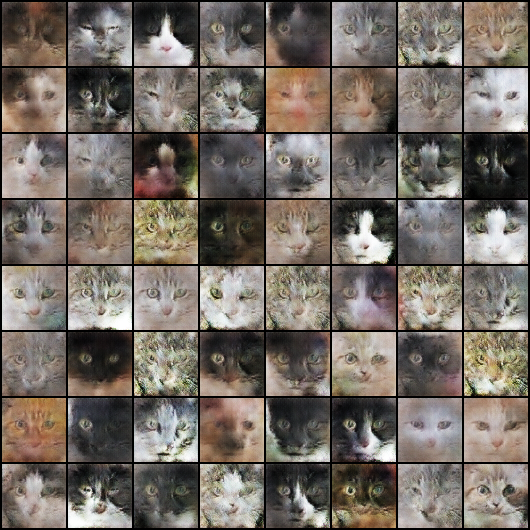

In [133]:
Image('./generated/generated-images-0060.png')

In [134]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

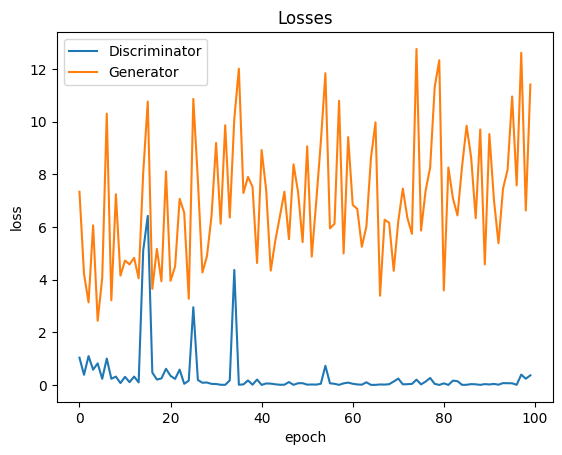

In [135]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

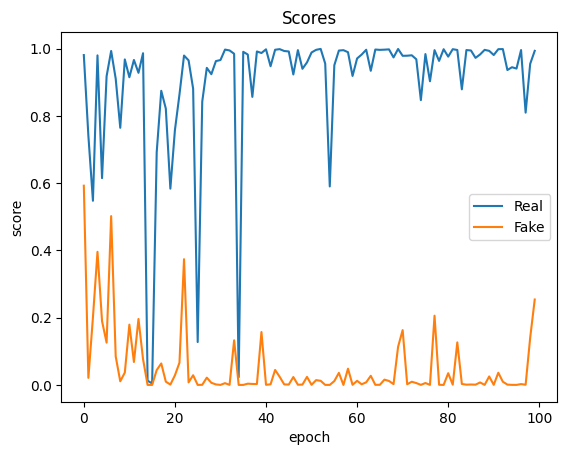

In [136]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');